# 3. Multi-class Vnet on BV

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1 Setup Torch Global Variable, load memory map 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 1
NUM_WORKERS = 6
NUM_TRAIN = 80
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [3]:
#-------------------------LOAD THE DATA SET-------------------------------------------#

data_index = np.arange(107)
data_index = np.delete(data_index, 46)
dataset_trans = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(2),
                             RandomFilp(0.5),
                             RandomAffine(15, 10)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([1, 1, 96, 128, 128]) torch.Size([1, 3, 96, 128, 128])
1 torch.Size([1, 1, 96, 128, 128]) torch.Size([1, 3, 96, 128, 128])
2 torch.Size([1, 1, 96, 128, 128]) torch.Size([1, 3, 96, 128, 128])
3 torch.Size([1, 1, 96, 128, 128]) torch.Size([1, 3, 96, 128, 128])


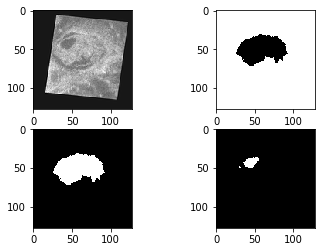

In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE, level=4)
        break

In [5]:
from vnet import VNet

#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

model = VNet(classnum=3, slim=False)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train(model, train_loader, validation_loader, optimizer,\
      device=device, dtype=dtype, epochs=500)

Epoch 0 finished ! Training Loss: 0.11399783590171911
     validation loss = 0.0748
Change Currculum! Reset LR Counter!


In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'Vet_currculum_326.pth'
torch.save(model.state_dict(), PATH)

## Checking the result

* load model dict from *.pth state dict
* show low res image slice
* save image to file

In [ ]:
from training import check_img
PATH = 'Vet_currculum_326.pth'

model = VNet(classnum=3, slim=False)
model.load_state_dict(torch.load(PATH))
model = model.to(device=device)
model.eval()

data_index = np.arange(5)
dataset_test = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(4),
                         ])
                     )

validation_loader = DataLoader(dataset_test, batch_size=1)

check_img(model, validation_loader, device, dtype)